# Neural Network Classifier 

We are going to build a PyTorch neural network classifier using scRNAseq data. 

Helpful link:
Interfacing pytorch models with anndata: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html

Possibly helpful about speeding up pytorch modeling: https://sebastianraschka.com/blog/2023/pytorch-faster.html

This program will:

- pull in scRNAseq data from cell_census
- wrangle the data for modelling
- appply the NN

## Urgent:
- should parent_dict be calculated in preprocess_data to ensure data consistency?


## To Do:

- feature engineering to remove useless genes
- update documentation
- add overall title to results plot to give context


## Done:
- use softmax for final layer
- use Cross entropy loss
- try ADAM optimizer, adjust learning rate
- plot loss curve
- use RELU for each layer
- plot accuracy curve
- add model.trend() and model.eval()
- add batch summarization 
- ensure that leaf order matches in all the things
- when splitting the data for training/validation,  ensure that the number of genes is the same in both
- select only genes that are protein coding (~20k)
- update internal_node_loss so that it sums the losses for each cell, then divides to get the average
- add internal node loss structure to the validation
- update metric plots to match outputs
- add accuracy/f1score etc. for internal nodes
- internal accuracy code
- rewrite output_probability_tensor to work for internal nodes only (probably done)




In [1]:
#import cellxgene_census as cell_census
import anndata as ad

import pronto
import warnings
warnings.filterwarnings("ignore", category=pronto.warnings.ProntoWarning)


import pandas as pd
import numpy as np
import copy
import time
import sys
import os
import pickle


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from torcheval.metrics.functional import multilabel_accuracy

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Read in the data

Great-lakes does not have internet access, so we pull in the data outside first, then load it here.

### Load Single Dataset

In [4]:
#adata = ad.read_h5ad('small_1044_900') # 42000 cells
#adata = ad.read_h5ad('leaf_list_in_cl') # 658000 cells
#adata = ad.read_h5ad('leaf_list_leukocyte_24Aug') # 516000 cells, 60k genes
#adata = ad.read_h5ad('leaf_list_leukocyte_6Sep_coding_genes') # 516k cells, 20k genes
#adata = ad.read_h5ad('leaf_list_hematopoietic_14Sep_coding_genes') # 549k cells, 20k genes, upper level hematopoietic (0000988)
#adata = ad.read_h5ad('1044_624_895_27Sep_coding_genes') # 230k cells, only CL1044 (leaf), 624 (internal), and 895 (leaf) including leaf and internal node
#adata = ad.read_h5ad('13Oct_2int_3leaf') #379k cells, 2 internal (576,624), 3 leaf (1044,895,2057)

adata = ad.read_h5ad('24Oct_hematopoietic_cells_p2') # 472k cells, part of the full hema data set


### Load Multiple Datasets and combine

In [3]:
# change into scratch directory (where data is saved)
os.chdir('/scratch/welchjd_root/welchjd99/fujoshua')

In [4]:
adata1 = ad.read_h5ad('24Oct_hematopoietic_cells_p1') # 1.98 million cells
adata2 = ad.read_h5ad('24Oct_hematopoietic_cells_p2') # 472k cells



In [5]:
adata = ad.concat([adata1,adata2]) #2.45 million

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
# delete adata1 and adata2 to save memory
del adata1
del adata2

In [13]:
adata

AnnData object with n_obs × n_vars = 2455115 × 19966
    obs: 'cell_type_ontology_term_id', 'assay', 'is_primary_data'

In [14]:
adata1

AnnData object with n_obs × n_vars = 1982772 × 19966
    obs: 'cell_type_ontology_term_id', 'assay', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [15]:
adata2

AnnData object with n_obs × n_vars = 472343 × 19966
    obs: 'cell_type_ontology_term_id', 'assay', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

### Load the Cell Ontology


In [5]:
cl = pronto.Ontology.from_obo_library('cl.owl')


In [ ]:
display(adata)

## Checking memory allocations



In [44]:
print(torch.cuda.memory_reserved()*1e-9)
print(torch.cuda.memory_allocated()*1e-9)

16.275996672
4.5691356160000005


In [45]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


In [47]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                         adata:  7.9 GiB
                        y_data: 44.9 MiB
                           ___: 54.6 KiB
                   ontology_df: 54.6 KiB
                           _12: 54.6 KiB
              ontology_leaf_df: 43.6 KiB
                          _i23: 21.0 KiB
                          _i26: 21.0 KiB
                          _i35: 20.9 KiB
                          _i30: 20.9 KiB


In [ ]:
# del adata

## Plotting Functions

In [6]:
def plot_results(marginalization_dict,num_epochs,save_title=None):
    fig, ax = plt.subplots(3,2,figsize=(9,9))
    
    
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_leaf_hist'], 
                    ax = ax[0,0],color='lightcoral',label='Train')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_leaf_hist'], 
                    ax = ax[0,0],color='mediumslateblue',label='Validation')
    
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_internal_hist'],
                   ax = ax[0,1],color='lightcoral',label='Train')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_internal_hist'],
                   ax = ax[0,1],color='mediumslateblue',label='Validation')
    
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_hist'], 
                    ax = ax[1,0],color='lightcoral')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_hist'], 
                    ax = ax[1,0],color='mediumslateblue')
    
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_leaf_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='X',label='Train Leafs')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_parents_hist'], 
                    ax = ax[1,1],color='lightcoral',label='Train Parents')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='v',label='Train Internal')

    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_leaf_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='X',label='Val Leafs')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_parents_hist'], 
                    ax = ax[2,0],color='mediumslateblue',label='Val Parents')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='v',label='Val Internal')


    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_leaf'], 
                    ax = ax[2,1],color='lightcoral',label='Train')
    sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_leaf'], 
                    ax = ax[2,1],color='mediumslateblue',label='Validation')

    
    ax[0,0].set_xlabel('Epoch')
    ax[0,1].set_xlabel('Epoch')
    ax[1,0].set_xlabel('Epoch')
    ax[1,1].set_xlabel('Epoch')
    ax[2,0].set_xlabel('Epoch')
    ax[2,1].set_xlabel('Epoch')


    ax[0,0].set_ylabel('Leaf Accuracy')
    ax[0,1].set_ylabel('Internal Accuracy')
    ax[1,0].set_ylabel('Total Loss')
    ax[1,1].set_ylabel('Training Loss')
    ax[2,0].set_ylabel('Validation Loss')
    ax[2,1].set_ylabel('F1 Score')


    # set the boundary for the accuracy plots
    #ax[0,1].set_ylim((50,100))
    
    # turn off the axis for subplot 2,1
    #ax[2,1].axis('off')
    
    if save_title:
        plt.savefig(save_title)




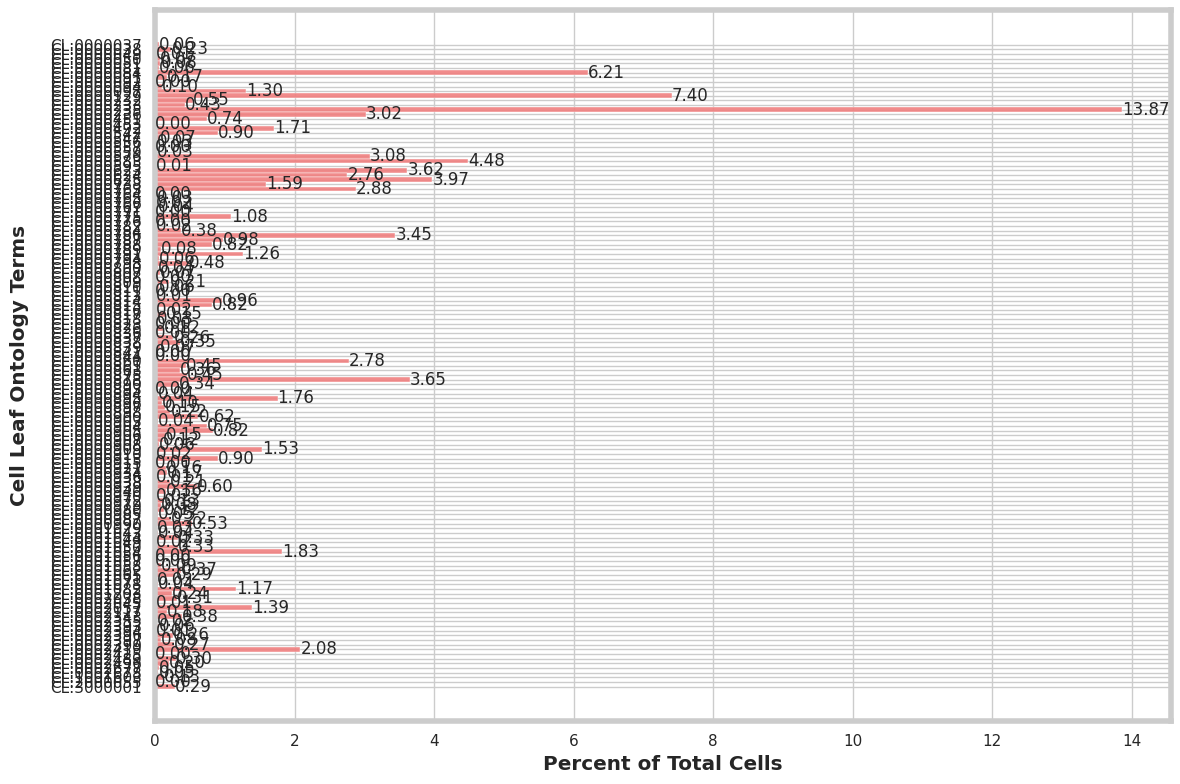

In [9]:
cell_ids = adata.obs['cell_type_ontology_term_id']

plt.figure(figsize=(12,8))

plots = sns.histplot(y=cell_ids,stat='percent',color='lightcoral',alpha=0.9)
# stat can also be probability or percent

plots.bar_label(plots.containers[0],fmt='%.2f')


#plt.xticks(rotation=90)
plt.ylabel('Cell Leaf Ontology Terms',labelpad=15)
plt.xlabel('Percent of Total Cells')

plt.show()

For the leucokyte dataset of 516,447 cells, the cell ID with the smallest percentage of data is CL:0001076, which makes up 0.00677 percent of the dataset. This corresponds to about 35 cells. The cell ID with the largest percentage is CL:0000895, which makes up 19.59 percent of the dataset. This corresponds to about 101,200 cells. 

In [10]:
plt.figure(figsize=(8,12))


plots = sns.histplot(y=y_train.cpu(),stat='count',color='lightcoral',alpha=0.9)
# stat can also be probability or percent
plots.bar_label(plots.containers[0],fmt='%.2f')


#plt.xticks(rotation=90)
plt.ylabel('Cell Leaf Ontology Terms',labelpad=15)
plt.xlabel('Count of Total Cells')

plt.show()

NameError: name 'y_train' is not defined

<Figure size 800x1200 with 0 Axes>

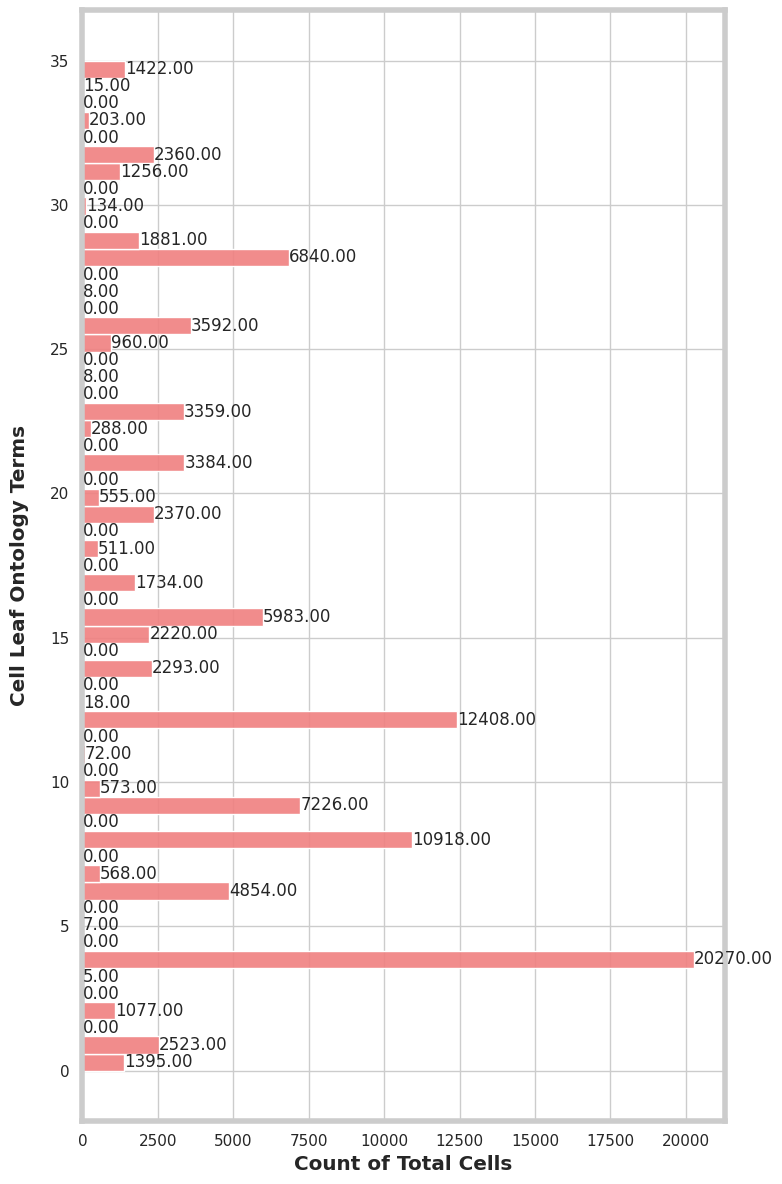

In [51]:
plt.figure(figsize=(8,12))


plots = sns.histplot(y=y_val.cpu(),stat='count',color='lightcoral',alpha=0.9)
# stat can also be probability or percent

plots.bar_label(plots.containers[0],fmt='%.2f')


#plt.xticks(rotation=90)
plt.ylabel('Cell Leaf Ontology Terms',labelpad=15)
plt.xlabel('Count of Total Cells')

plt.show()

In [25]:
#print(pd.DataFrame(y_train.cpu()).value_counts())

#print(pd.DataFrame(y_val.cpu()).value_counts())

difference_df = pd.Series(y_train.cpu()).value_counts(normalize=True) - pd.Series(y_val.cpu()).value_counts(normalize=True)



In [26]:
difference_df.head()

0    0.000160
1   -0.000525
2   -0.000051
3    0.000034
4   -0.000359
Name: proportion, dtype: float64

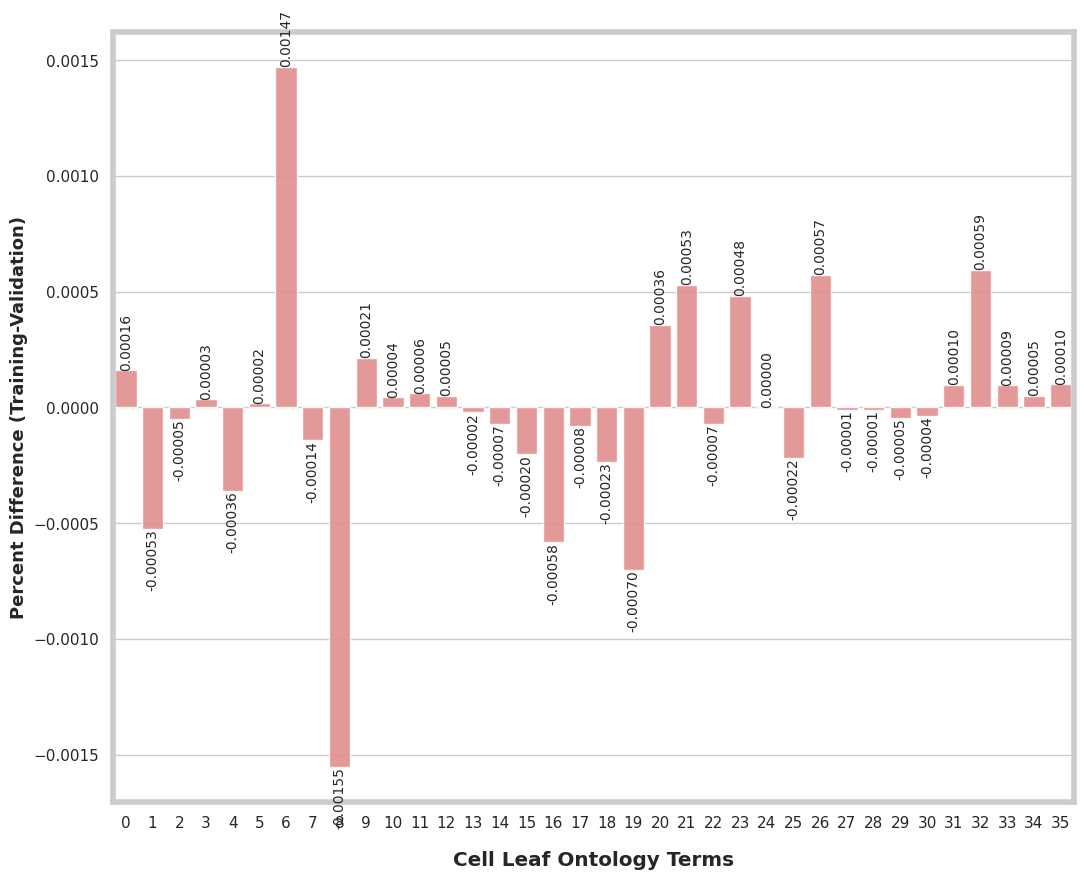

In [31]:
plt.figure(figsize=(11,9))


plots = sns.barplot(x=difference_df.index, y=difference_df.values,
            color='lightcoral',alpha=0.9)

plots.bar_label(plots.containers[0],fmt='%.5f',rotation=90,fontsize=10)

#plt.xticks(rotation=90)
plt.ylabel('Percent Difference (Training-Validation)', fontsize=13)
plt.xlabel('Cell Leaf Ontology Terms',labelpad=15)

plt.show()

## Encode and Split the Data into Train/Validate to prepare for modeling

Encode the label values, then split the data into testing and training sets, then put into PyTorch Tensors.


In [7]:
def preprocess_data(adata, target_column):
    '''
    This function perfroms preprocessing on ann AnnData object to prepare it for modelling. It will encode the 
    target column and returns x_data and y_data for modelling
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # encode the target column
    #lb = LabelEncoder()
    #labels['encoded_labels'] = lb.fit_transform(labels[target_column])
    
    # we want to only encode the targets that are leafs. We will leave 
    # internal nodes as the CL number in order to assist with masking 
    # the appropriate parent nodes 
    # first, get list of all cell values
    all_cell_values = labels[target_column].unique().to_list()
    
    # identify which values are leafs
    # we use positive number for leaf values
    # and negative number for internal nodes
    mapping_dict = {}
    leaf_values = []
    internal_values = []
    encoded_leaf_val = 0
    encoded_internal_val = -9999
    for term in all_cell_values:
        if cl[term].is_leaf():
            mapping_dict[term] = encoded_leaf_val
            leaf_values.append(term)
            encoded_leaf_val += 1
        else:
            # check if internal values have associated sub-values in the dataset
            #    sub-values do not have to be leafs
            # if so, add value as internal values
            # if not, prune ontology so consider 
            term_subvalues = []
            # get leaf values of this term
            for sub_term in cl[term].subclasses(distance=None,with_self=False).to_set():
                    term_subvalues.append(sub_term.id)
            
            # get values in all_call_values in term_leafs
            intersection_list = list(set(all_cell_values).intersection(term_subvalues))
            if len(intersection_list) == 0:
                mapping_dict[term] = encoded_leaf_val
                leaf_values.append(term)
                encoded_leaf_val += 1
            else:
                mapping_dict[term] = encoded_internal_val
                internal_values.append(term)
                encoded_internal_val += 1            
            
            
    # use the leaf_mapping_dict to 
    labels['encoded_labels'] = labels[target_column].map(mapping_dict)
    
    x_data = adata.X.copy()
    y_data = labels['encoded_labels']
    
    return(x_data,y_data, mapping_dict, leaf_values, internal_values)

In [7]:
def preprocess_data_ontology(adata, target_column,upper_limit = None, cl_only = False, include_leafs = False):
    '''
    This function perfroms preprocessing on ann AnnData object to prepare it for modelling. It will encode the 
    target column and returns x_data and y_data for modelling
    
    This function also preprocesses the ontology to build a pandas dataframe that can be used to 
    calculate predicted probabilities. This will enable simple matrix multiplication to calculate
    probabilities and loss.
    
    Can have an upper limit to the ontology if upper_limit is set
    
    
    Assumes there is an active census object already open as cl. 

    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
     
    upper_limit : string
        if you want to specify an upper limit in the ontology, set this to 
        the upper limit (inclusive)
        Default: None (no limit to ontology)
        
    cl_only : boolean
        option to only include the Cell Ontology (CL) in the dataframe
        True means only those cell IDs that start with CL are included
        Default: False
        
    include_leafs : boolean
        option to include leafs in the list of parent cell IDs
        Default is False because we are calculating the leaf loss differently
        Default: False
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
        
    mapping_dict : Dictionary
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes

    leaf_values : list
        list composed of all leaf values included in the dataset
        includes internal nodes that do not have sub-values in the dataset, and thus are
        treated an leaf nodes

    internal_values : list
        list composed of interanal nodes in the dataset

    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    parent_dict : dictionary
        dictionary where values are lists of Cell Ontology term IDs that are the parents (inclusive) 
        for the Cell Ontology Term ID key.

    
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # encode the target column
    #lb = LabelEncoder()
    #labels['encoded_labels'] = lb.fit_transform(labels[target_column])
    
    # we want to only encode the targets that are leafs. We will leave 
    # internal nodes as the CL number in order to assist with masking 
    # the appropriate parent nodes 
    # first, get list of all cell values
    all_cell_values = labels[target_column].unique().to_list()
    
    # identify which values are leafs
    # we use positive number for leaf values
    # and negative number for internal nodes
    mapping_dict = {}
    leaf_values = []
    internal_values = []
    encoded_leaf_val = 0
    encoded_internal_val = -9999
    for term in all_cell_values:
        if cl[term].is_leaf():
            mapping_dict[term] = encoded_leaf_val
            leaf_values.append(term)
            encoded_leaf_val += 1
        else:
            # check if internal values have associated sub-values in the dataset
            #    sub-values do not have to be leafs
            # if so, add value as internal values
            # if not, prune ontology so consider 
            term_subvalues = []
            # get leaf values of this term
            for sub_term in cl[term].subclasses(distance=None,with_self=False).to_set():
                    term_subvalues.append(sub_term.id)
            
            # get values in all_call_values in term_leafs
            intersection_list = list(set(all_cell_values).intersection(term_subvalues))
            if len(intersection_list) == 0:
                mapping_dict[term] = encoded_leaf_val
                leaf_values.append(term)
                encoded_leaf_val += 1
            else:
                mapping_dict[term] = encoded_internal_val
                internal_values.append(term)
                encoded_internal_val += 1            
            
            
    # use the leaf_mapping_dict to 
    labels['encoded_labels'] = labels[target_column].map(mapping_dict)
    
    x_data = adata.X.copy()
    y_data = labels['encoded_labels']
    
    #########
    # no get a list of all parent nodes for each value in the dataset
    # if we want to include leafs, set with_self= True
    # else, set with_self = False
    
    all_parent_nodes = []
    for target in all_cell_values:
        for term in cl[target].superclasses(distance=None,with_self=include_leafs).to_set():
            all_parent_nodes.append(term.id)
            
    # ensure that we do not have duplicate values
    all_parent_nodes = list(set(all_parent_nodes))

    # select only the Cell Ontology IDs if cl_only = True
    if cl_only:
        all_parent_nodes = [x for x in all_parent_nodes if x.startswith('CL')]
    
    # if there is an upper limit, 
    if upper_limit is not None:
        # get upper limit nodes
        upper_limit_nodes = []
        for term in cl[upper_limit].superclasses(distance=None,with_self=False).to_set():
            upper_limit_nodes.append(term.id)
            
        # remove these nodes from the parent_nodes list
        all_parent_nodes = [x for x in all_parent_nodes if x not in upper_limit_nodes]
        
        
    # create the dataframe
    # use all_cell_values for the columns, because we need both leafs and
    # internals nodes for mapping
    ontology_df = pd.DataFrame(data=0, index = all_parent_nodes,
                                              columns = all_cell_values)
    
    # populate the dataframe with 1 if column is a sub-node 
    # for that particular cell ID
    # with_self = True because we need to include the leafs here
    for cell_id in ontology_df.index:
        for term in cl[cell_id].subclasses(distance=None,with_self=True).to_set():
            if term.id in ontology_df.columns:
                ontology_df.loc[cell_id,[term.id]] = [1]

    # create a dictionary that maps parents to reduce the ontology_df when
    # dealing with internal nodes
    parent_dict = {}
    for parent in internal_values:
        super_parent_list = []
        for term in cl[parent].superclasses(distance=None,with_self=True).to_set():
            if term.id in all_parent_nodes:
                super_parent_list.append(term.id)
        parent_dict[parent] = super_parent_list

    
    return(x_data,y_data, mapping_dict, leaf_values, internal_values, ontology_df, parent_dict)

In [8]:
def transform_data(x_data):
    '''
    This function takes the input x_data, transforms the data with log(1+x) and 
    returns the transformed data
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    '''
    
    # np.log takes the natural log
    x_data.data = np.log(1+ x_data.data)

    return x_data

In [9]:
def split_format_data(x_data, y_data, train_size, val_size, holdout_size = None, random_state = None):
    '''
    This function splits x_data and y_data into training and validation sets, then formats the data into
    tensors for modeling with PyTorch
    
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    y_data : Series
        Pandas series of encoded target values
        
    train_size: float
        float between 0.0 and 1.0 to select the training fraction of the data set
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    '''
    
    
    if holdout_size:
        # split into training and validation sets
        # first split into train and validation/holdout
        X_train, X_val_holdout, y_train, y_val_holdout = train_test_split(x_data,y_data,
                                                       train_size = train_size,
                                                         random_state=random_state)

        # calculate the validation split of the remainder 
        val_split_size = val_size / (val_size + holdout_size)

        # split the validation/holdout set to separate sets
        X_val, X_holdout, y_val, y_holdout = train_test_split(X_val_holdout, y_val_holdout,
                                                             train_size = val_split_size,
                                                             random_state=random_state)
    else:
        # split into training and validation sets
        # first split into train and validation/holdout
        X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,
                                                       train_size = train_size,
                                                         random_state=random_state)

    
    # check if number of genes in X_train = X_val
    # rarely, splitting the dataset can cause a difference
    # if it does, resplit the data by looping back into this function

    if holdout_size:
        if (X_train.shape[1] != X_val.shape[1]) or (X_train.shape[1] != X_holdout.shape[1]):
            X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state = None)
        else:
            print('Success. Number of genes in datasets match.')
    else:
        if (X_train.shape[1] != X_val.shape[1]):
            X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state = None)
        else:
            print('Success. Number of genes in datasets match.')


    
    # convert the data to tensors
    # we'll change the data from CSR (compressed sparse row) format
    # to COO (coordinate) format for better use with pytorch
    # see https://pytorch.org/docs/stable/sparse.html for additional details
    # conversion from COO to tensor based on https://stackoverflow.com/questions/50665141/converting-a-scipy-coo-matrix-to-pytorch-sparse-tensor


    X_train_coo = X_train.tocoo()
    #X_train = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_train_coo.row,X_train_coo.col))),
    #                              torch.FloatTensor(X_train_coo.data))

    X_train_values = X_train_coo.data
    X_train_indices = np.vstack((X_train_coo.row, X_train_coo.col))

    X_train_i = torch.LongTensor(X_train_indices)
    X_train_v = torch.FloatTensor(X_train_values)
    X_train_shape = X_train_coo.shape

    X_train = torch.sparse.FloatTensor(X_train_i, X_train_v, torch.Size(X_train_shape))  
    
    
    
    # y_train is a Series, so it is easier to convert to a tensor
    y_train = torch.tensor(y_train)#, dtype=torch.long)


    # and the same for the validation set
    X_val_coo = X_val.tocoo()
    #X_val = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_val_coo.row,X_val_coo.col))),
    #                                  torch.FloatTensor(X_val_coo.data))

    
    X_val_values = X_val_coo.data
    X_val_indices = np.vstack((X_val_coo.row, X_val_coo.col))

    X_val_i = torch.LongTensor(X_val_indices)
    X_val_v = torch.FloatTensor(X_val_values)
    X_val_shape = X_val_coo.shape

    X_val = torch.sparse.FloatTensor(X_val_i, X_val_v, torch.Size(X_val_shape))  

    
    
    # y_val is a Series, so it is easier to convert to a tensor
    y_val = torch.tensor(y_val)#, dtype=torch.long)

    if holdout_size:
        # and the same for the holdout set
        X_holdout_coo = X_holdout.tocoo()
        #X_holdout = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_holdout_coo.row,X_holdout_coo.col))),
        #                              torch.FloatTensor(X_holdout_coo.data))

        X_holdout_values = X_holdout_coo.data
        X_holdout_indices = np.vstack((X_holdout_coo.row, X_holdout_coo.col))

        X_holdout_i = torch.LongTensor(X_holdout_indices)
        X_holdout_v = torch.FloatTensor(X_holdout_values)
        X_holdout_shape = X_holdout_coo.shape

        X_holdout = torch.sparse.FloatTensor(X_holdout_i, X_holdout_v, torch.Size(X_holdout_shape))  

        
        # y_holdout is a Series, so it is easier to convert to a tensor
        y_holdout = torch.tensor(y_holdout, dtype=torch.long)
    
    if device.type == "cuda":
        print('Moving tensors to GPU. X_train WILL NOT be moved to GPU. ')
        #X_train = X_train.to(device) # this saves of memory space
        y_train = y_train.to(device)
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        if holdout_size:
            X_holdout = X_holdout.to(device)
            y_holdout = y_holdout.to(device)
            
    if holdout_size:
        return(X_train, X_val, y_train, y_val, X_holdout, y_holdout)
    else:
        return(X_train, X_val, y_train, y_val)

In [18]:
def preprocess_ontology(adata,target_column,upper_limit = None, include_leafs = False, cl_only = False, only_leafs_for_targets=False):
    '''
    This function processes the ontology to build a pandas dataframe that can be used to 
    calculate predicted probabilities. This will enable simple matrix multiplication to calculate
    probabilities and loss.
    
    Can have an upper limit to the ontology if upper_limit is set
    
    
    Assumes there is an active census object already open as cl. 
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
    upper_limit : string
        if you want to specify an upper limit in the ontology, set this to 
        the upper limit (inclusive)
        Default: None (no limit to ontology)
        
    include_leafs : boolean
        option to include leafs in the list of parent cell IDs
        Default is False because we are calculating the leaf loss differently
        Default: False
        
    cl_only : boolean
        option to only include the Cell Ontology (CL) in the dataframe
        True means only those cell IDs that start with CL are included
        Default: False
        
    only_leafs_for_targets : boolean
        option to specify that targets are already known to include leafs
        Default: False - program will check all targets and find any additional leafs
                True means that list of unique values in the target column will be used

        
    Returns
    -------
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    parent_dict : dictionary
        dictionary where values are lists of Cell Ontology term IDs that are the parents (inclusive) 
        for the Cell Ontology Term ID key.
        
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # select the unique target values
    target_values = labels[target_column].unique()
    
    # check that these are leaf nodes
    # if not, find the leaf under that value
    
    if only_leafs_for_targets:
        leaf_nodes = target_values
    else:
        leaf_nodes = []
        for target in target_values:
            if cl[target].is_leaf():
                leaf_nodes.append(target)
            else:
                for term in cl[target].subclasses(distance=None,with_self=False).to_set():
                    if term.is_leaf():
                        leaf_nodes.append(term.id)
    
    # ensure that we do not have duplicate values
    leaf_nodes = list(set(leaf_nodes))
    
    
    # now get all parent nodes
    # if we want to include leafs, set with_self = True
    # else, set with_self = False
    parent_nodes = []
    for target in target_values:
        for term in cl[target].superclasses(distance=None,with_self=include_leafs).to_set():
            parent_nodes.append(term.id)
            
    # ensure that we do not have duplicate values
    parent_nodes = list(set(parent_nodes))

    # select only the Cell Ontology IDs if cl_only = True
    if cl_only:
        parent_nodes = [x for x in parent_nodes if x.startswith('CL')]
    
    # if there is an upper limit, 
    if upper_limit is not None:
        # get upper limit nodes
        upper_limit_nodes = []
        for term in cl[upper_limit].superclasses(distance=None,with_self=False).to_set():
            upper_limit_nodes.append(term.id)
            
        # remove these nodes from the parent_nodes list
        parent_nodes = [x for x in parent_nodes if x not in upper_limit_nodes]
        
    
    # create the dataframe
    ontology_df = pd.DataFrame(data=0, index = parent_nodes,
                                              columns = leaf_nodes)


    # populate the dataframe with 1 if column leaf is a leaf 
    # for that particular cell ID
    # with_self = True because we need to include the leafs here
    for cell_id in ontology_df.index:
        for term in cl[cell_id].subclasses(distance=None,with_self=True).to_set():
            if term.id in ontology_df.columns:
                ontology_df.loc[cell_id,[term.id]] = [1]
                    
    # create a dictionary that maps parents to reduce the ontology_df when
    # dealing with internal nodes
    parent_dict = {}
    for parent in parent_nodes:
        super_parent_list = []
        for term in cl[parent].superclasses(distance=None,with_self=True).to_set():
            if term.id in parent_nodes:
                super_parent_list.append(term.id)
        parent_dict[parent] = super_parent_list
        
        
    return(ontology_df, parent_dict)

In [10]:
target_column = 'cell_type_ontology_term_id'

upper_limit = 'CL:0000988' # leukocyte = 738, hematopoietic = 988

print('start preprocess data and ontology')
x_data,y_data, mapping_dict, leaf_values, internal_values, ontology_df, parent_dict =  preprocess_data_ontology(adata, target_column,upper_limit = upper_limit, cl_only = True, include_leafs = False)


# create dataframe that only includes leaf nodes
ontology_leaf_df = ontology_df[leaf_values]

print('start transforming data')
x_data = transform_data(x_data)


train_size = 0.8
val_size = 0.2
holdout_size = None # None if you don't want holdout set
random_state = 42
print('start split and format data')
if holdout_size:
    X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state=random_state)
else:
    X_train, X_val, y_train, y_val = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state=random_state)



start preprocess data and ontology
start transforming data
start split and format data
Success. Number of genes in datasets match.
Moving tensors to GPU. X_train WILL NOT be moved to GPU. 


In [17]:
# save information needed for testing external models 
# this included the ontology dfs, mapping dict, leaf_values, internal_values

os.chdir('/home/fujoshua/cell_classification')
#ontology_df.to_csv('ontology_df_17Nov.csv')
#ontology_leaf_df.to_csv('ontology_leaf_df_17Nov.csv')

mapping_dict_df = pd.DataFrame.from_dict(mapping_dict,orient='index')
mapping_dict_df.to_csv('mapping_dict_df_17Nov.csv')


with open("leaf_values_17Nov", "wb") as fp:   #Pickling
    pickle.dump(leaf_values, fp)
    
with open("internal_values_17Nov", "wb") as fp:   #Pickling
    pickle.dump(internal_values, fp)



In [12]:
mapping_dict

{'CL:0000583': 0,
 'CL:0000861': 1,
 'CL:1001603': -9999,
 'CL:0000766': -9998,
 'CL:0000765': 2,
 'CL:0002496': -9997,
 'CL:0000898': -9996,
 'CL:0000903': 3,
 'CL:0000813': -9995,
 'CL:0000910': 4,
 'CL:0000838': -9994,
 'CL:0000826': -9993,
 'CL:0000051': 5,
 'CL:0000817': 6,
 'CL:0000839': -9992,
 'CL:0000837': -9991,
 'CL:0001029': 7,
 'CL:0000050': 8,
 'CL:0000547': 9,
 'CL:0002355': 10,
 'CL:0002045': 11,
 'CL:0000559': 12,
 'CL:0000816': 13,
 'CL:0001054': -9990,
 'CL:0000836': 14,
 'CL:0000557': 15,
 'CL:0000556': 16,
 'CL:0000092': 17,
 'CL:0000938': 18,
 'CL:0000936': 19,
 'CL:0000771': 20,
 'CL:0002419': -9989,
 'CL:0001082': 21,
 'CL:0002489': 22,
 'CL:0001071': 23,
 'CL:0002425': 24,
 'CL:0000915': 25,
 'CL:0000789': -9988,
 'CL:0000904': 26,
 'CL:0002396': 27,
 'CL:0000934': 28,
 'CL:0000940': 29,
 'CL:0000907': 30,
 'CL:0002677': 31,
 'CL:0002678': 32,
 'CL:0001057': 33,
 'CL:0000091': 34,
 'CL:0000939': 35,
 'CL:0001203': -9987,
 'CL:0002038': 36,
 'CL:0001062': 37,
 '

In [11]:
leaf_values

['CL:0000583',
 'CL:0000861',
 'CL:0000765',
 'CL:0000903',
 'CL:0000910',
 'CL:0000051',
 'CL:0000817',
 'CL:0001029',
 'CL:0000050',
 'CL:0000547',
 'CL:0002355',
 'CL:0002045',
 'CL:0000559',
 'CL:0000816',
 'CL:0000836',
 'CL:0000557',
 'CL:0000556',
 'CL:0000092',
 'CL:0000938',
 'CL:0000936',
 'CL:0000771',
 'CL:0001082',
 'CL:0002489',
 'CL:0001071',
 'CL:0002425',
 'CL:0000915',
 'CL:0000904',
 'CL:0002396',
 'CL:0000934',
 'CL:0000940',
 'CL:0000907',
 'CL:0002677',
 'CL:0002678',
 'CL:0001057',
 'CL:0000091',
 'CL:0000939',
 'CL:0002038',
 'CL:0001062',
 'CL:0000844',
 'CL:0000979',
 'CL:0002117',
 'CL:0000595',
 'CL:0000810',
 'CL:0000811',
 'CL:0002057',
 'CL:0002397',
 'CL:0000800',
 'CL:0001058',
 'CL:0000818',
 'CL:0001043',
 'CL:0001049',
 'CL:0000776']

In [13]:
#print(mapping_dict)
print(parent_dict)
#print(len(leaf_values))
#print(len(internal_values))

{'CL:1001603': ['CL:0000325', 'CL:0000235', 'CL:0002242', 'CL:1001603', 'CL:0000473', 'CL:0000255', 'CL:0000234', 'CL:0000988', 'CL:0000219', 'CL:0000766', 'CL:0000145', 'CL:0000738', 'CL:0000763'], 'CL:0000766': ['CL:0000255', 'CL:0000738', 'CL:0000763', 'CL:0000219', 'CL:0000988', 'CL:0002242', 'CL:0000766'], 'CL:0002496': ['CL:0002496', 'CL:0002242', 'CL:0000842', 'CL:0002419', 'CL:0000226', 'CL:0000255', 'CL:0000988', 'CL:0000219', 'CL:0000542', 'CL:0000738', 'CL:0000084'], 'CL:0000898': ['CL:0002242', 'CL:0000842', 'CL:0002419', 'CL:0000226', 'CL:0000255', 'CL:0000988', 'CL:0000219', 'CL:0000542', 'CL:0000738', 'CL:0000084', 'CL:0000898'], 'CL:0000813': ['CL:0000813', 'CL:0002242', 'CL:0000842', 'CL:0002419', 'CL:0000226', 'CL:0000255', 'CL:0000988', 'CL:0000219', 'CL:0000542', 'CL:0000738', 'CL:0000084'], 'CL:0000838': ['CL:0011026', 'CL:0008001', 'CL:0000988', 'CL:0002031', 'CL:0000838', 'CL:0011115'], 'CL:0000826': ['CL:0000838', 'CL:0011115', 'CL:0011026', 'CL:0008001', 'CL:00

In [19]:
target_column = 'cell_type_ontology_term_id'

upper_limit = 'CL:0000988' # leukocyte = 738, hematopoietic = 988

print('start preprocess ontology')
ontology_df, parent_dict = preprocess_ontology(adata,target_column,upper_limit = upper_limit, include_leafs = False, cl_only=True,only_leafs_for_targets=False)

print('start preprocess data')
x_data, y_data, mapping_dict, leaf_values, internal_values = preprocess_data(adata,target_column)

# create dataframe that only includes leaf nodes
ontology_leaf_df = ontology_df[leaf_values]

print('start transforming data')
x_data = transform_data(x_data)

train_size = 0.8
val_size = 0.2
holdout_size = None # None if you don't want holdout set
random_state = 42
print('start split and format data')
if holdout_size:
    X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state=random_state)
else:
    X_train, X_val, y_train, y_val = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state=random_state)


start preprocess ontology
start preprocess data
start transforming data
start split and format data
Success. Number of genes in datasets match.


In [20]:
print(leaf_values)

['CL:0000583', 'CL:0000861', 'CL:0000765', 'CL:0000903', 'CL:0000910', 'CL:0000051', 'CL:0000817', 'CL:0001029', 'CL:0000050', 'CL:0000547', 'CL:0002355', 'CL:0002045', 'CL:0000559', 'CL:0000816', 'CL:0000836', 'CL:0000557', 'CL:0000556', 'CL:0000092', 'CL:0000938', 'CL:0000936', 'CL:0000771', 'CL:0001082', 'CL:0002489', 'CL:0001071', 'CL:0002425', 'CL:0000915', 'CL:0000904', 'CL:0002396', 'CL:0000934', 'CL:0000940', 'CL:0000907', 'CL:0002677', 'CL:0002678', 'CL:0001057', 'CL:0000091', 'CL:0000939', 'CL:0002038', 'CL:0001062', 'CL:0000844', 'CL:0000979', 'CL:0002117', 'CL:0000595', 'CL:0000810', 'CL:0000811', 'CL:0002057', 'CL:0002397', 'CL:0000800', 'CL:0001058', 'CL:0000818', 'CL:0001043', 'CL:0001049', 'CL:0000776']


In [20]:
print(mapping_dict)
print(parent_dict)
print(leaf_values)
print(internal_values)

{'CL:0000583': -9999, 'CL:0000861': -9998, 'CL:1001603': -9997, 'CL:0000766': -9996, 'CL:0000765': -9995, 'CL:0002496': -9994, 'CL:0000898': -9993, 'CL:0000903': 0, 'CL:0000813': -9992, 'CL:0000910': 1, 'CL:0000838': -9991, 'CL:0000826': -9990, 'CL:0000051': -9989, 'CL:0000817': -9988, 'CL:0000839': -9987, 'CL:0000837': -9986, 'CL:0001029': 2, 'CL:0000050': -9985, 'CL:0000547': -9984, 'CL:0002355': 3, 'CL:0002045': 4, 'CL:0000559': 5, 'CL:0000816': -9983, 'CL:0001054': -9982, 'CL:0000836': -9981, 'CL:0000557': -9980, 'CL:0000556': -9979, 'CL:0000092': -9978, 'CL:0000938': 6, 'CL:0000936': 7, 'CL:0000771': -9977, 'CL:0002419': -9976, 'CL:0001082': -9975, 'CL:0002489': -9974, 'CL:0001071': -9973, 'CL:0002425': 8, 'CL:0000915': 9, 'CL:0000789': -9972, 'CL:0000904': 10, 'CL:0002396': 11, 'CL:0000934': 12, 'CL:0000940': 13, 'CL:0000907': 14, 'CL:0002677': -9971, 'CL:0002678': -9970, 'CL:0001057': 15, 'CL:0000091': 16, 'CL:0000939': 17, 'CL:0001203': -9969, 'CL:0002038': -9968, 'CL:0001062':

In [21]:
ontology_df

,CL:0002678,CL:0000789,CL:0000800,CL:0002489,CL:0000556,CL:0000051,CL:0001057,CL:0002117,CL:0000765,CL:0000092,...,CL:0002038,CL:0000810,CL:1001603,CL:0000771,CL:0000557,CL:0000938,CL:0001203,CL:0000844,CL:0000837,CL:0000817
CL:0002032,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CL:0000234,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CL:0000473,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CL:0000897,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CL:0000219,1,1,1,1,0,0,1,1,0,1,...,1,1,1,1,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CL:0001012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CL:0000623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CL:0000909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CL:0000837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
# save validation data

torch.save(X_val, 'X_val_17Nov.pt')
torch.save(y_val,'y_val_17Nov.pt')

In [27]:
y_val

tensor([-9984,     0,     1,  ...,    21,    27,    18], device='cuda:0')

In [12]:
X_train

tensor(indices=tensor([[     0,      0,      0,  ..., 439661, 439661, 439661],
                       [    83,    107,    115,  ...,  18327,  18356,  18448]]),
       values=tensor([0.6931, 1.0986, 0.6931,  ..., 0.6931, 0.6931, 0.6931]),
       size=(439662, 19922), nnz=730197156, layout=torch.sparse_coo)

In [18]:
X_train.values

<function Tensor.values>

In [21]:
#print(X_train.is_cpu)
#print(X_val.is_cuda())
#print(y_train.get_device())
#print(y_val.is_cuda())
type(X_train)

print('X_train size in MB: ', X_train.element_size() * X_train.nelement() * 10e-6)

print('X_val size in MB: ', X_val.element_size() * X_val.nelement() * 10e-6)

print('y_train size in MB: ', y_train.element_size() * y_train.nelement() * 10e-6)

print('y_val size in MB: ', y_val.element_size() * y_val.nelement() * 10e-6)


X_train size in MB:  329236.55016000004
X_val size in MB:  82309.73520000001
y_train size in MB:  33.05256
y_val size in MB:  8.263200000000001


In [13]:
# check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1

print(X_train.get_device())
print(X_val.get_device())
print(y_train.get_device())
print(y_val.get_device())


-1
0
0
0


In [14]:
print(X_train.shape)
print(y_train.shape)


print(X_val.shape)
print(y_val.shape)

print(X_holdout.shape)
print(y_holdout.shape)


torch.Size([377874, 19966])
torch.Size([377874])
torch.Size([94469, 19966])
torch.Size([94469])


NameError: name 'X_holdout' is not defined

In [24]:
y_train

tensor([ 9, 23, 14,  ..., 12, 17,  4], device='cuda:0')

## Build Neural Network Classifier


In [11]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of neurons for hidden layers
hidden_layer_1 = 256
hidden_layer_2 = 128

# number of classes (unique of y)
output_dim = torch.unique(y_train[y_train >= 0]).size(dim=0) #labels['encoded_labels'].nunique()

print(input_dim,hidden_layer_1,hidden_layer_2,output_dim)

19966 256 128 52


In [12]:
class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layer_1)
        self.linear2 = nn.Linear(hidden_layer_1,hidden_layer_2)
        self.linear3 = nn.Linear(hidden_layer_2,output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x,dim=1)
        return x

In [ ]:
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layer_1)
        self.linear2 = nn.Linear(hidden_layer_1,output_dim)
        self.bn = nn.BatchNorm1d(hidden_layer_1)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.softmax(x,dim=1)
        return x

## Functions for dealing with tree ontology and loss


In [13]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted normalized probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
    ontology_tensor = ontology_tensor.to(device)
        
    # convolve the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk
    
    # if there is only a single column for the ontology, change shape to match expected value
    if len(ontology_tensor.shape) == 1:
        ontology_tensor = ontology_tensor.unsqueeze(1)    
    
    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    #print('sum_prob', sum_probability_tensor.shape)
        
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )
    
    return sum_probability_tensor


In [14]:
def target_probability_tensor(target_values,ontology_df):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation
    
    Parameters
    ----------
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor

    for count, target_value in enumerate(target_values):
        sub_target_tensor = torch.tensor(ontology_df.iloc[:,target_value.item()].values,dtype=float).reshape(-1,1)

        if count == 0 :
            target_tensor = sub_target_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,sub_target_tensor),1).requires_grad_()
    target_tensor = target_tensor.to(device)
    return target_tensor

In [15]:
def internal_target_probability_tensor(target_values,ontology_df):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation. Very similar to target_probability_tensor, but
    specific for dealing with internal node classifications only
    
    All cells are of the same type
    
    Parameters
    ----------    
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and column is single cell ID
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.DoubleTensor(ontology_df.values).unsqueeze(1) 
    ontology_tensor = ontology_tensor.to(device)
            
    # if there is only a single column for the ontology, change shape to match expected value
    #if len(ontology_tensor.shape) == 1:
    #    ontology_tensor = ontology_tensor.unsqueeze(1)    

    
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    for count, target_value in enumerate(target_values):
        if count == 0 :
            target_tensor = ontology_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,ontology_tensor),1).requires_grad_()
    target_tensor = target_tensor.to(device)
    return target_tensor

In [16]:
def internal_node_loss(output_internal,y_batch_internal,internal_values,mapping_dict,ontology_df,ontology_leaf_df,criterion_parents,threshold):
    '''
    Calculate the loss for cells whose target values are internal nodes. This function loops through each
    internal nodes value listed in internal_values, selects the predicted and target values for that
    cell, calculates the loss for the cell, then calculates the mean loss for all internal nodes
    
    Parameters
    ----------
    output_internal : Tensor
        pytorch tensor of output values from the classifier for all internal nodes
        
    y_batch_internal : Tensor
        pytorch tensor of target values for all internal nodes
        
    internal_values : list
        list of Cell Ontology IDs for internal nodes included in the dataset
        
    mapping_dict : dict
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes
        
    ontology_df : DataFrame
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    ontology_leaf_df : DataFrame
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are onlys leafs in portion of ontology being queried. 
        Differs from ontology_df in that columns do not include any internal nodes.
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.

    criterion_parents : loss function
        pytorch loss function used to calculate the loss for the internal nodes
        
    threshold : float
        value between 0 and 1 to set for making predictions. If the predicted probability is
        equal to or greater than threshold, we consider that a true prediction

    Returns
    -------    
    mean_internal_node_loss : tensor
        pytorch single-value tensor with the mean loss for all internal 
        nodes in the dataset
    '''
    # we will store the losses in a list, then calculate the mean 
    # at the end
    stored_losses = []
    
    # we need to get a list of the internal values in this batch of data
    encoded_values_batch = y_batch_internal.unique().tolist()
    #print(encoded_values_batch)
    internal_values_batch = []
    for x in encoded_values_batch:
        internal_values_batch.append(next(key for key, value in mapping_dict.items() if value == x))
    
    for internal_cell in internal_values_batch:
        # get the encoded value for this cell
        map_value = mapping_dict[internal_cell]
        
        # use the encoded value to select the predicted and known values 
        # for that cell
        output_cell_internal = output_internal[y_batch_internal == map_value]
        y_cell_internal = y_batch_internal[y_batch_internal == map_value]
        
        # use output_probability_tensor to sum the predicted probabilities
        # up the whole ontology,
        output_parent_prob_all = output_probability_tensor(output_cell_internal,ontology_leaf_df)
        # select the rows that are relevant for this internal node
        
        # get the relevant ontology dataframe
        # pick the correct column
        ontology_internal_cell_df = ontology_df[internal_cell]
        ontology_internal_cell_values = torch.FloatTensor(ontology_internal_cell_df.values)
        ontology_internal_cell_values = ontology_internal_cell_values.to(device)

        # multiple the ontology by the predictions to zero out the values
        # that don't apply for this cell

        output_parent_prob_all_internal = ontology_internal_cell_values[:,None] * output_parent_prob_all         

        # remove the rows that are zeros
        output_parent_prob_all_internal = output_parent_prob_all_internal[output_parent_prob_all_internal.sum(dim=1) != 0]

        # select and pick the relevant rows of the ontology df
        internal_rows_list = parent_dict[internal_cell]
        #print('internal_rows_list (parent dict[internal cell])',internal_rows_list)
        parent_indices = [ontology_internal_cell_df.index.get_loc(row) for row  in internal_rows_list]
        #print('parent_indices',parent_indices)
        ontology_internal_cell_df_sc = ontology_internal_cell_df[parent_indices]

        # now we can calculate the probability tensors for the
        # predicted and known values
        ###output_parent_prob = output_probability_tensor(output_cell_internal,ontology_internal_cell_df)
        target_parent_prob = internal_target_probability_tensor(y_cell_internal,ontology_internal_cell_df_sc)

        #print('output_parent_prob_all_internal',output_parent_prob_all_internal.shape)
        #print('target_parent_prob',target_parent_prob.shape)
        
        # and then we calculate the BCE loss and store the value for this cell
        cell_loss = criterion_parents(output_parent_prob_all_internal,target_parent_prob)
        stored_losses.append(cell_loss.item())
        
        # we need to calculate the accuracy here because the number of
        # cells and internal parent nodes will vary for each internal cell
        # we will track the amount of data so we can weight appropriately 
        # when combining
                
        # calculate the accuracy
        # use the threshold value to convert input into predicted labels
        accuracy_cell =  multilabel_accuracy(output_parent_prob_all_internal,target_parent_prob,
                                            threshold=threshold,criteria='hamming')

        # save the number of cells for this node, for use in weighting when
        # determining the overall accuracy
        number_of_cells = output_parent_prob_all_internal.shape[1]
        
        # save the accuracy and number of cell values
        if internal_cell == internal_values_batch[0]:
            # if this is the first loop, initialize
            # the tensors we'll save
            total_accuracy_cell = accuracy_cell.reshape(1)
            total_number_of_cells = torch.tensor(number_of_cells).reshape(1)
        else:
            # append tensors for saving
            total_accuracy_cell = torch.cat((total_accuracy_cell,accuracy_cell.reshape(1)),0)
            total_number_of_cells = torch.cat((total_number_of_cells,torch.tensor(number_of_cells).reshape(1)),0)
            
    
    # take the mean of the loss values for each cell ID
    # this gives us the mean loss for all internal nodes
    mean_internal_node_loss = torch.tensor(np.mean(stored_losses))
    
    # move total number of cells to GPU, if available
    # total accuracy cell is already on GPU, if available
    total_number_of_cells = total_number_of_cells.to(device)
    
        
    return mean_internal_node_loss, total_accuracy_cell, total_number_of_cells
       

# Marginalization Classification 

- Based on Dahll, et al., Hierarchical Image Classification using Entailment Cone Embeddings, CVPR 202
- https://arxiv.org/pdf/2004.03459.pdf
- Thesis slides: https://ankitdhall.github.io/publication/learning-representations-for-images-with-hierarchical-labels/master_thesis.pdf
- First Author website: https://ankitdhall.github.io/project/learning-representations-for-images-with-hierarchical-labels/

Outline:
1) Forward Propogation
2) Get outputs (outputs_train)
3) get probability dictionary for outputs (add_probability_to_parent_nodes).
4) get tree structure and run softmax on each layer
5) use y_train to make probability dictionary y tree
6) calculate the loss across all levels



## Marginalization with DataLoader

In [30]:
def marginalization_classification_with_batches(train_loader,X_val,y_val,num_epochs,ontology_df):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    train_loader : DataLoader Tensor
        pytorch tensor of training and target values from Pytorch DataLoader
    
    X_val : Tensor
        pytorch tensor of validation values
                
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_hist : list
            list containing accuracy for the training set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        accuracy_val_hist : list 
            list containing accuracy for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch

    '''
    # initialize variables for saving values
    accuracy_train_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_hist = []
    accuracy_val_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []

    best_accuracy = - np.inf
    best_weights = None

    # initialize network
    clf = Network()
    clf.to(device)

    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize both here
    criterion_leafs = nn.CrossEntropyLoss()
    criterion_parents = nn.BCELoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        print('on epoch', epoch)
        
        # TRAINING
        clf.train()
        running_train_loss = 0.0
        #running_accuracy = 0.0
        #running_vallidation_loss = 0.0
        #total = 0
        
        correct_train = 0
        y_length = 0
        #i = -1
        start_loop = time.time()

        for i, (X_train, y_train) in enumerate(train_loader):
            end_loop = time.time()
            print('time elapsed:', (end_loop-start_loop))
            #if i % 50 == 0:
            print('on batch', i)

            # every data instance is input + label pair
            #X_train = X_train.to(device)
            #y_train = y_train.to(device)
            
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            
            # make predictions for this batch
            outputs_train = clf(X_train) # might need to change to X_train.float()
            
            # calculate loss for just the leafs
            loss_train_leafs = criterion_leafs(outputs_train, y_train)

            # calculate the loss for the parents
            output_train_parent_prob = output_probability_tensor(outputs_train,ontology_df)
            target_train_parent_prob = target_probability_tensor(y_train,ontology_df)

            loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

            # sum the loss for both leafs and parents
            loss_train = loss_train_leafs + loss_train_parents

            # backward propagation
            loss_train.backward()

            # optimize
            optimizer.step()
 
            running_train_loss += loss_train.item()
    
            # save accuracy
            _, train_pred_per_epoch = outputs_train.max(dim=1)
            #print(train_pred_per_epoch)
            #print(y_train)
            correct_train += (train_pred_per_epoch == y_train).sum().item()
            #print(correct_train)
            y_length += len(y_train)
            #print(y_length)
            #print('current accuracy:', (correct_train/y_length *100))
            #print('current loss:', loss_train.item())
            #print('')            
   

        # save accuracy
        #_, train_pred = outputs_train.max(dim=1)
        #correct_train = (train_pred == y_train).sum().item()
        #print(correct_train)
        #print(y_length)
        accuracy_train_hist.append(correct_train / y_length * 100.)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())

        
        with torch.no_grad():
            clf.eval()
            # calculate output by running through the network
            outputs_val = clf(X_val.float())

            # get the predictions
            __, predicted_val = outputs_val.max(dim=1)            
            
            # calculate loss for just the leafs
            loss_val_leafs = criterion_leafs(outputs_val, y_val)
        
            # calculate the loss for the parents
            output_val_parent_prob = output_probability_tensor(outputs_val,ontology_df)
            target_val_parent_prob = target_probability_tensor(y_val,ontology_df)
            
            loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

            # sum the loss for both leafs and parents
            loss_val = loss_val_leafs + loss_val_parents
            
            # save accuracy
            correct_val = (predicted_val == y_val).sum().item()
            accuracy_val_hist.append(correct_val / len(y_val) * 100.)

            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())

            
            # check if best model
            if accuracy_val_hist[-1] > best_accuracy:
                best_acc = accuracy_val_hist[-1]
                best_weights = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_hist[-1]:.8f} Validation Accuracy: {accuracy_val_hist[-1]:.8f}')

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    #print('Best Weights: ')
    #print(best_weights)
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_hist'] = accuracy_train_hist
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_parents_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_hist'] = accuracy_val_hist
    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_parents_hist'] = loss_val_parents_hist
    
    marginalization_dict['best_output'] = best_output

    #return(accuracy_train_hist, loss_train_hist, loss_train_leaf_hist, loss_train_parents_hist, accuracy_val_hist, loss_val_hist, loss_val_leaf_hist, loss_val_parents_hist, best_output)
    return marginalization_dict


In [20]:
print(X_train.shape[0]/128)

4114.0625


In [31]:
# create the DataLoader datsets for batch purposes

#X_train = X_train.to('cpu')
#y_train = y_train.to('cpu')
#print(X_train.get_device(),y_train.get_device())

train_set = torch.utils.data.TensorDataset(X_train,y_train)

# set these if on GPU 
#kwargs = {'num_workers': 0, 'pin_memory': True} if device.type=='cuda' else {}
kwargs = {'num_workers': 0} if device.type=='cuda' else {}


batch_size = 1024
# set drop_last = True to drop the last batch iff it is a different size

print('Number of batches is ', (X_train.shape[0]/batch_size))
train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size=batch_size,shuffle=True,drop_last=True,**kwargs)


num_epochs = 6

number_of_leafs = labels['encoded_labels'].unique().size
number_of_parents = ontology_df.shape[0]

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

start = time.time()
marginalization_dict = marginalization_classification_with_batches(train_loader,X_val,y_val,num_epochs, ontology_df)
end = time.time()

print('run time:', (end-start))

Number of batches is  32.8251953125
There are 2 leafs and 12 parents.
on epoch 0
time elapsed: 206.50590801239014
on batch 0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_SparseCUDA__addmm)

In [ ]:
plot_results(marginalization_dict,num_epochs)


## Marginalization with Manual Batches

In [30]:
def marginalization_classification_manual_batch(X_train,X_val,y_train,y_val,num_epochs,ontology_leaf_df, 
                                                batch_size,internal_values,mapping_dict,
                                               ontology_df, threshold):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_leaf_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are onlys leafs in portion of ontology being queried. 
        Differs from ontology_df in that columns do not include any internal nodes.
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    
    batch_size : int
        integer specificying the number of samples processed before the model
        is updated
        
    internal_values : list
        list of Cell Ontology IDs for internal nodes included in the dataset
        
    mapping_dict : dict
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes
    
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are leafs and internal nodes in portion of ontology being 
        queried. 
        Differs from ontology_leaf_df in that columns include both leaf and internal node values
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    threshold : float
        value between 0 and 1 to set for making predictions. If the predicted probability is
        equal to or greater than threshold, we consider that a true prediction

        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_leaf_hist : list
            list containing accuracy for leaf values for the training set per epoch
            
        accuracy_train_internal_hist : list
            list containing accuracy for internal values for the trainig set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        loss_train_internal_hist : list
            list containing loss values for internal nodes for the training set per epoch
        
        accuracy_val_leaf_hist : list 
            list containing accuracy for leaf values for the validation set per epoch
        
        accuracy_val_internal_hist : list
            list containing accuracy for internal values for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        loss_val_internal_hist : list
            list containing loss values for internal nodes for the validation set per epoch
        
        f1_score_train_leaf : list
            list containing Macro F1 score for leaf nodes for training set per epoch 
        
        f1_score_val_leaf : list
            list containing Macro F1 score for leaf nodes for validation set per epoch 
        
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch
            
        best_state_dict : dictionary
            Pytorch state_dict that contains the parameters for the best fitting models
    '''
    # initialize variables for saving values
    accuracy_train_leaf_hist = []
    accuracy_train_internal_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_internal_hist = []
    loss_train_hist = []
    
    accuracy_val_leaf_hist = []
    accuracy_val_internal_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []
    loss_val_internal_hist = []
    
    f1_score_train_leaf = []
    f1_score_val_leaf = []

    best_accuracy = - np.inf
    best_weights = None
    
    # get the list of leaf labels
    leaf_label_list = [value for (key,value) in mapping_dict.items() if value >= 0]

    # initialize network
    clf = Network2()
    clf.to(device)

    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize both here
    criterion_leafs = nn.CrossEntropyLoss(reduction='mean')
    criterion_parents = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)#, amsgrad=True, eps=1e-5)
    #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)

    #start_epoch = time.time()
    for epoch in range(num_epochs):
        #print('on epoch', epoch)
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        
        running_train_loss = 0.0
        #correct_train = 0
        #y_length = 0
                
        # set up manual batches - from https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
        permutation = torch.randperm(X_train.size()[0]).to(device)
        permutation_cpu = permutation.cpu() # we want the same permutations, but need one copy on the cpu

        #start = time.time()
        for i in range(0,X_train.size()[0], batch_size):
            #if (i/batch_size) % 10 == 0:
            #print('on batch', i/batch_size, 'running time', (time.time()-start))

            indices = permutation[i:i+batch_size]
            indices_cpu = permutation_cpu[i:i+batch_size]
            #X_batch, y_batch = X_train[indices], y_train[indices] # doesn't work for sparse tensors

            X_batch = torch.index_select(X_train,0,indices_cpu).to(device)

            y_batch = torch.index_select(y_train,0,indices)#.to(device)

            
            # check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1
            #print(X_batch.get_device())
            #print(y_batch.get_device())
            
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            
            # make predictions for this batch
            outputs_train = clf(X_batch.float()) # might need to change to X_train.float()
            
            ######
            # create mask to separate leaf and internal nodes
            ######
            output_train_leaf = outputs_train[y_batch >= 0]
            y_batch_leaf = y_batch[y_batch >= 0]
            
            output_train_internal = outputs_train[y_batch < 0]
            y_batch_internal = y_batch[y_batch < 0]
            

            # calculate loss for just the leafs
            loss_train_leafs = criterion_leafs(output_train_leaf, y_batch_leaf)

            # calculate the loss for the parents of the cells that are leafs
            output_train_parent_prob = output_probability_tensor(output_train_leaf,ontology_leaf_df)
            target_train_parent_prob = target_probability_tensor(y_batch_leaf,ontology_leaf_df)

            loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

            #######
            # calculate the loss for the cells that are internal nodes
            ##### total_accuracy_cell, total_number_of_cells
            
            loss_train_internal, batch_accuracy_internal, batch_numbers_internal = internal_node_loss(
                                                    output_train_internal,y_batch_internal,
                                                     internal_values,mapping_dict,ontology_df,
                                                    ontology_leaf_df,criterion_parents,threshold)
            
            # sum the loss for both leafs and parents
            loss_train = loss_train_leafs + loss_train_parents + loss_train_internal

            # backward propagation
            loss_train.backward()

            # optimize
            optimizer.step()
             
            running_train_loss += loss_train.item()
           
            # save accuracy
            _, train_leaf_pred_per_epoch = output_train_leaf.max(dim=1)

            
            # check size of internal tensors. if only 1 internal cell
            # reshape and detach
            # else just detach
            
            if len(batch_accuracy_internal.size()) == 0:
                batch_accuracy_internal_shaped = batch_accuracy_internal.detach().reshape(1)
                batch_numbers_internal_shaped = batch_numbers_internal.detach().reshape(1)
            else:
                batch_accuracy_internal_shaped = batch_accuracy_internal.detach()
                batch_numbers_internal_shaped = batch_numbers_internal.detach()
                
            
            if i == 0:
                train_leaf_pred_total = train_leaf_pred_per_epoch.detach()
                y_train_leaf_total = y_batch_leaf.detach()
                train_batch_accuracy_internal = batch_accuracy_internal_shaped
                train_numbers_internal = batch_numbers_internal_shaped
            else:
                train_leaf_pred_total = torch.cat((train_leaf_pred_total,train_leaf_pred_per_epoch.detach()),0)
                y_train_leaf_total = torch.cat((y_train_leaf_total,y_batch_leaf.detach()),0)
                train_batch_accuracy_internal = torch.cat((train_batch_accuracy_internal,batch_accuracy_internal_shaped),0)
                train_numbers_internal = torch.cat((train_numbers_internal,batch_numbers_internal_shaped),0)
                            
            # calculate total epoch accuracy for internal nodes
            #epoch_internal_accuracy = / train_numbers_internal.sum() * 100
            
            #correct_train += (train_pred_per_epoch == y_batch).sum().item()
            #y_length += len(y_batch)
            
            # calculate F1 score
            #f1_val_score_epoch = f1_score(train_pred_per_epoch.cpu(),y_batch.cpu(),labels=output_dim,average='weighted',zero_division=np.nan)

        scheduler.step()
        
        # save accuracy
        #_, train_pred = outputs_train.max(dim=1)
        #correct_train = (train_pred == y_train).sum().item()
        #accuracy_train_hist.append(correct_train / y_length * 100.)
        #print('acc train hist', accuracy_train_hist[-1])
        
        correct_train_leaf = (train_leaf_pred_total == y_train_leaf_total).sum().item()
        accuracy_train_leaf_hist.append(correct_train_leaf / train_leaf_pred_total.shape[0] * 100.)
        
        correct_train_internal = (train_batch_accuracy_internal * train_numbers_internal).sum()
        accuracy_train_internal = (correct_train_internal / train_numbers_internal.sum() * 100.).item()
        accuracy_train_internal_hist.append(accuracy_train_internal)
        
        #print('sample acc', acc_full)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())
        loss_train_internal_hist.append(loss_train_internal.item())
        
        # save f1 score
        # use average = weighted to account for label imbalance
        # use zero_division = np.nan to exclude labels where all 
        #       predictions and labels are negative
        f1_train_leaf_score = f1_score(train_leaf_pred_total.cpu(), y_train_leaf_total.cpu(),
                                  labels=leaf_label_list,average='weighted',zero_division=np.nan)
        f1_score_train_leaf.append(f1_train_leaf_score)
        
        # set up validation
        correct_val = 0
        y_val_length = 0
        
        with torch.no_grad():
            clf.eval()
            
            # set up manual batches
            # we don't need to randomly permute the validation set, but
            # this will provide consistency with the above.
            # for simplicity, let's use the same batch size
            permutation_val = torch.randperm(X_val.size()[0]).to(device)
            #start_val = time.time()
            for i in range(0,X_val.size()[0],batch_size):
            
                indices_val = permutation_val[i:i+batch_size]
                
                X_val_batch = torch.index_select(X_val,0,indices_val)
                y_val_batch = torch.index_select(y_val,0,indices_val)
                
            
                # calculate output by running through the network
                outputs_val = clf(X_val_batch.float())
            
                ######
                # create mask to separate leaf and internal nodes
                ######
                output_val_leaf = outputs_val[y_val_batch >= 0]
                y_val_batch_leaf = y_val_batch[y_val_batch >= 0]

                output_val_internal = outputs_val[y_val_batch < 0]
                y_val_batch_internal = y_val_batch[y_val_batch < 0]
            
                # calculate loss for just the leafs
                loss_val_leafs = criterion_leafs(output_val_leaf, y_val_batch_leaf)
        
                # calculate the loss for the parents of the leafs
                output_val_parent_prob = output_probability_tensor(output_val_leaf,ontology_leaf_df)
                target_val_parent_prob = target_probability_tensor(y_val_batch_leaf,ontology_leaf_df)
                
                loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

                #######
                # calculate the loss for the cells that are internal nodes
                #####

                loss_val_internal, batch_accuracy_internal_val, batch_numbers_internal_val = internal_node_loss(output_val_internal,
                                                                y_val_batch_internal,
                                                                internal_values,mapping_dict,ontology_df,ontology_leaf_df,
                                                                criterion_parents,threshold)

                
                # sum the loss for both leafs and parents
                loss_val = loss_val_leafs + loss_val_parents + loss_val_internal
            
            
                # get the predictions
                __, predicted_leaf_val_per_epoch = output_val_leaf.max(dim=1)            

                # save accuracy
                #correct_val += (predicted_val_per_epoch == y_val_batch).sum().item()
                #y_val_length += len(y_val_batch)
                
                # check size of internal tensors. if only 1 internal cell
                # reshape and detach
                # else just detach
                            
                if len(batch_accuracy_internal_val.size()) == 0:
                    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach().reshape(1)
                    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach().reshape(1)
                else:
                    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach()
                    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach()
                                
                if i == 0:
                    val_leaf_pred_total = predicted_leaf_val_per_epoch.detach()
                    y_leaf_val_total = y_val_batch_leaf.detach()
                    val_batch_accuracy_internal = batch_accuracy_internal_val_shaped
                    val_numbers_internal = batch_numbers_internal_val_shaped

                else:
                    val_leaf_pred_total = torch.cat((val_leaf_pred_total,predicted_leaf_val_per_epoch.detach()),0)
                    y_leaf_val_total = torch.cat((y_leaf_val_total,y_val_batch_leaf.detach()),0)
                    val_batch_accuracy_internal = torch.cat((val_batch_accuracy_internal,batch_accuracy_internal_val_shaped),0)
                    val_numbers_internal = torch.cat((val_numbers_internal,batch_numbers_internal_val_shaped),0)               
                
            # save total accuracy
            #accuracy_val_hist.append(correct_val / y_val_length * 100.)
            
            correct_val_leaf = (val_leaf_pred_total == y_leaf_val_total).sum().item()
            accuracy_val_leaf_hist.append(correct_val_leaf / val_leaf_pred_total.shape[0] * 100.)

            correct_val_internal = (val_batch_accuracy_internal * val_numbers_internal).sum()
            accuracy_val_internal = (correct_val_internal / val_numbers_internal.sum() * 100.).item()
            accuracy_val_internal_hist.append(accuracy_val_internal)

            
            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())
            loss_val_internal_hist.append(loss_val_internal.item())
            
            # save f1 score
            # use average = weighted to account for label imbalance
            # use zero_division = np.nan to exclude labels where all 
            #       predictions and labels are negative
            f1_val_leaf_score = f1_score(val_leaf_pred_total.cpu(), y_leaf_val_total.cpu(),
                                    labels=leaf_label_list,average='weighted',zero_division=np.nan)
            f1_score_val_leaf.append(f1_val_leaf_score)

            
            # check if best model
            if accuracy_val_leaf_hist[-1] > best_accuracy:
                best_acc = accuracy_val_leaf_hist[-1]
                best_state_dict = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 1 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_leaf_hist[-1]:.3f} Validation Accuracy: {accuracy_val_leaf_hist[-1]:.3f}')
            print(f'Train Loss: {loss_train.item():.4f} Validation Loss: {loss_val.item():.4f}')
            #print(f'Internal Loss: {loss_val_internal.item():.4f}')
            #print('learning rate:', optimizer.param_groups[0]["lr"])
        #end_epoch = time.time()
        #print('epoch timer', end_epoch-start_epoch)

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_leaf_hist'] = accuracy_train_leaf_hist
    marginalization_dict['accuracy_train_internal_hist'] = accuracy_train_internal_hist
    
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_parents_hist'] = loss_train_parents_hist
    marginalization_dict['loss_train_internal_hist'] = loss_train_internal_hist

    marginalization_dict['accuracy_val_leaf_hist'] = accuracy_val_leaf_hist
    marginalization_dict['accuracy_val_internal_hist'] = accuracy_val_internal_hist

    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_parents_hist'] = loss_val_parents_hist
    marginalization_dict['loss_val_internal_hist'] = loss_val_internal_hist
    
    marginalization_dict['f1_score_train_leaf'] = f1_score_train_leaf
    marginalization_dict['f1_score_val_leaf'] = f1_score_val_leaf

    marginalization_dict['best_output'] = best_output
    marginalization_dict['best_state_dict'] = best_state_dict


    return marginalization_dict


In [22]:
print(mapping_dict)
print(parent_dict)
print(leaf_values)
print(internal_values)
print(output_dim)

{'CL:0000576': -9999, 'CL:0000624': -9998, 'CL:0000895': 0, 'CL:0001044': 1, 'CL:0002057': 2}
{'CL:0000911': ['CL:0000911', 'CL:0000226', 'CL:0000842', 'CL:0002419', 'CL:0000084', 'CL:0000738', 'CL:0000542'], 'CL:0000325': ['CL:0000325'], 'CL:0001054': ['CL:0001054', 'CL:0000226', 'CL:0000842', 'CL:0000576', 'CL:0000763', 'CL:0000766', 'CL:0000738', 'CL:0011026', 'CL:0011115'], 'CL:0000226': ['CL:0000226'], 'CL:0000473': ['CL:0000473'], 'CL:0000789': ['CL:0000789', 'CL:0000842', 'CL:0000738', 'CL:0000542', 'CL:0000084', 'CL:0000226'], 'CL:0000842': ['CL:0000738', 'CL:0000842', 'CL:0000226'], 'CL:0002419': ['CL:0000842', 'CL:0002419', 'CL:0000738', 'CL:0000542', 'CL:0000084', 'CL:0000226'], 'CL:0000084': ['CL:0000842', 'CL:0000738', 'CL:0000542', 'CL:0000084', 'CL:0000226'], 'CL:0000624': ['CL:0000226', 'CL:0000789', 'CL:0000842', 'CL:0002419', 'CL:0000084', 'CL:0000624', 'CL:0000738', 'CL:0000542', 'CL:0000791'], 'CL:0000576': ['CL:0000226', 'CL:0000842', 'CL:0000576', 'CL:0000763', 'C

**For 2 GPUs**

Moving X_train to CPU, manually load batch, then move x_train to GPU with batch size of 128 = 3.4s per batch

Same as above, but a batch size of 128 = 3.37s per batch

same as above, with batch size of 1024 = 3.58s per batch

same as above, with batch size of 4096 = 4.62s per batch


same as above, but 1 GPU, batch size of 4096 = 4.4s per batch

### trouble shooting same accuracy issue

- 680k cells, with a learning rate of 0.1, train accuracy maxes at 24.06076719, validation at 24.03038359 after 2 epochs. Validation was constant from epoch 1, training increased by ~0.5 from epoch 1 to 2.

- 42k cells, learning rate of 0.1, train accuracy maxes at 59.12890846 after 5 epochs with very little change before then, validation at 59.53117563 after the first epoch

- 42k cells, learning rate of 1e-3, training accuracy changes by about 0.02 after the first two epochs (around 59.10213310), validation accuracy changing by ~0.03 after first epoch (around 59.50737744). 

- 42k cells, change model to 5 hidden layers instead of 10, learning rate 1e-3, training waffles around 59.11105822, validation around 59.87624941

*Change the permutations to a single one, for both gpu and cpu*

- 42k cells, 10 hidden layers, lr 1e-3, both accuracy's quickly at 98 or 99 percent


In [18]:
num_epochs = 10

number_of_leafs = len(leaf_values)
number_of_parents = len(internal_values)

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

batch_size = 4096 #
print('Number of training batches is ', (X_train.shape[0]/batch_size))
print('Number of validation batches is ', (X_val.shape[0]/batch_size))


# set the prediction threshold for internal nodes
threshold = 0.8
print('Prediction threshold for internal nodes is', threshold)

start = time.time()

marginalization_dict = marginalization_classification_manual_batch(X_train,X_val,y_train,y_val,
                                                                   num_epochs, ontology_leaf_df, batch_size,
                                                                  internal_values,mapping_dict,
                                                                  ontology_df,threshold)

end = time.time()

time_minutes = (end-start)/60.
time_hours = (end-start)/3600.

print(f'Run time for {num_epochs} epochs was {time_minutes:.2f} minutes ({time_hours:.2f} hours)')


There are 52 leafs and 16 parents.
Number of training batches is  92.25439453125
Number of validation batches is  23.063720703125
Prediction threshold for internal nodes is 0.8
[1] Training Accuracy: 71.844 Validation Accuracy: 84.857
Train Loss: 3.1706 Validation Loss: 3.1866
[2] Training Accuracy: 87.914 Validation Accuracy: 90.959
Train Loss: 3.0926 Validation Loss: 3.1050
[3] Training Accuracy: 92.983 Validation Accuracy: 93.254
Train Loss: 3.0593 Validation Loss: 3.0681
[4] Training Accuracy: 94.231 Validation Accuracy: 94.111
Train Loss: 3.0393 Validation Loss: 3.0522
[5] Training Accuracy: 95.037 Validation Accuracy: 94.631
Train Loss: 3.0309 Validation Loss: 3.0204
[6] Training Accuracy: 96.248 Validation Accuracy: 95.794
Train Loss: 3.0301 Validation Loss: 3.0398
[7] Training Accuracy: 96.748 Validation Accuracy: 95.883
Train Loss: 3.0148 Validation Loss: 3.0349
[8] Training Accuracy: 97.144 Validation Accuracy: 96.338
Train Loss: 3.0117 Validation Loss: 3.0189
[9] Training Ac

In [52]:
ontology_df['CL:0000813'].value_counts()

CL:0000813
0    77
1    11
Name: count, dtype: int64

In [38]:
parent_dict.keys()

dict_keys(['CL:1001603', 'CL:0000797', 'CL:0000875', 'CL:0002032', 'CL:0002496', 'CL:0000775', 'CL:0000798', 'CL:0001054', 'CL:0000911', 'CL:0000785', 'CL:0000906', 'CL:0001035', 'CL:0000826', 'CL:0000624', 'CL:0000860', 'CL:0000909', 'CL:0001065', 'CL:0000839', 'CL:0000219', 'CL:4030002', 'CL:0001067', 'CL:0008001', 'CL:0000791', 'CL:0000893', 'CL:0000766', 'CL:0000782', 'CL:0001056', 'CL:0000784', 'CL:0000473', 'CL:0000764', 'CL:0000084', 'CL:0000576', 'CL:0000763', 'CL:0000815', 'CL:0000864', 'CL:0001200', 'CL:0000232', 'CL:0000235', 'CL:0002417', 'CL:0000813', 'CL:0000898', 'CL:0002031', 'CL:0011115', 'CL:0000789', 'CL:0001019', 'CL:0001204', 'CL:0002420', 'CL:0000081', 'CL:0001203', 'CL:0000896', 'CL:0000451', 'CL:0000945', 'CL:0000145', 'CL:0000225', 'CL:0000972', 'CL:0000623', 'CL:0000790', 'CL:0000792', 'CL:0000988', 'CL:0002092', 'CL:0002242', 'CL:0001201', 'CL:0002191', 'CL:0000787', 'CL:0000842', 'CL:0001012', 'CL:0001060', 'CL:0000838', 'CL:0000625', 'CL:0011026', 'CL:00003

In [77]:
test = torch.tensor([0.33,.2]).to(device)
#test = test.to(device)
#test.nelement() == 1
#test.unique()
test.get_device()


0

In [47]:
if len(test.size()) == 0:
    print('zero')

else:
    for count, target_value in enumerate(test):
        print(count,target_value)


0 tensor(0.3300)
1 tensor(0.2000)


In [71]:
device


device(type='cuda', index=0)

In [116]:
print (end-start)


349.0620286464691


In [117]:
410.53738141059875/60/1


6.842289690176646

In [26]:
6.842289690176646*30/60


3.421144845088323

so 30 minutes for 1 epoch with a batch size of 4096, and no batches for the validation set

51 minutes for 5 epochs eith batch size of 4096 for both train and validation

with batches for validation, about 10 minutes per epoch

In [19]:
# save the model parameters to a file

#marginalization_dict['best_state_dict']

torch.save(marginalization_dict['best_state_dict'],'17_Nov_best_model_leafonly')



In [25]:
# save the loss/accuracy/f1 scores to a file

cols_to_save = ['accuracy_train_leaf_hist', 'accuracy_train_internal_hist','loss_train_hist', 
                'loss_train_leaf_hist', 'loss_train_parents_hist', 
                'accuracy_val_leaf_hist', 'accuracy_val_internal_hist',
                'loss_val_hist', 'loss_val_leaf_hist', 'loss_val_parents_hist', 
                'f1_score_train_leaf', 'f1_score_val_leaf']

results_dict = {key: marginalization_dict[key] for key in cols_to_save}

results_df = pd.DataFrame.from_dict(results_dict, orient='columns')

results_df.insert(0,'epoch',range(1,num_epochs+1))

results_df.to_csv('17Nov_results_df_hematopoietic_leafonly.csv',index=False)



In [23]:
marginalization_dict.keys()


dict_keys(['accuracy_train_leaf_hist', 'accuracy_train_internal_hist', 'loss_train_hist', 'loss_train_leaf_hist', 'loss_train_parents_hist', 'loss_train_internal_hist', 'accuracy_val_leaf_hist', 'accuracy_val_internal_hist', 'loss_val_hist', 'loss_val_leaf_hist', 'loss_val_parents_hist', 'loss_val_internal_hist', 'f1_score_train_leaf', 'f1_score_val_leaf', 'best_output', 'best_state_dict'])

In [34]:
marginalization_dict['loss_train_parents_hist']


[0.026294866103970586,
 0.009042310521805473,
 0.004259996926057883,
 0.0037890718985408383,
 0.0018232005968956972,
 0.0015245055999911165]

In [109]:
marginalization_dict['loss_val_internal_hist']



[0.1578429864142073, 0.15054678315353828, 0.16314317127120187]

In [110]:
marginalization_dict['accuracy_train_internal_hist']

[57.29056167602539, 67.95557403564453, 69.49366760253906]

In [111]:
marginalization_dict['accuracy_val_internal_hist']

[62.47584915161133, 67.7135009765625, 68.53792572021484]

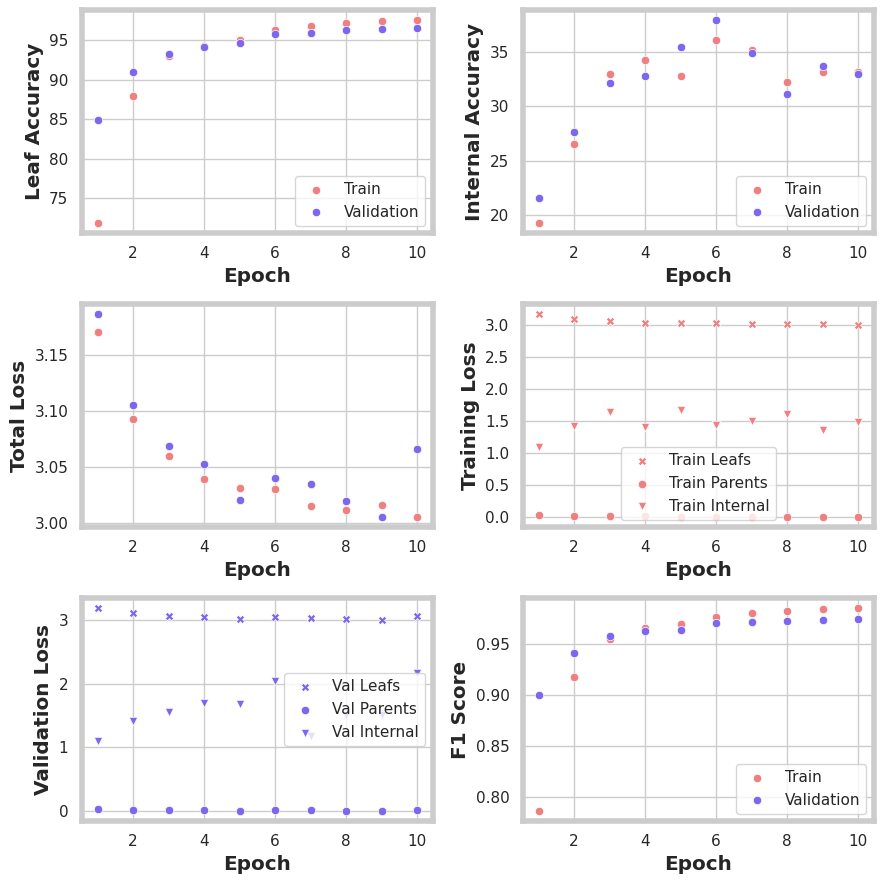

In [22]:
#plot_results(marginalization_dict,num_epochs,save_title='17Nov_results_hematopoietic_leafonly.png')

plot_results(marginalization_dict,num_epochs)


